In [48]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [50]:
import sys
import os

sys.path.append(r'C:\Program Files\QGIS 3.20.3\apps\qgis\python') #this is important for loading qgis library
sys.path.append(r'C:\Program Files\QGIS 3.20.3\apps\qgis\python\plugins') #this is important for loading processing library

In [51]:
import qgis
from qgis.gui import *
from qgis.core import *
from qgis.utils import plugins
from PyQt5.QtCore import *
from qgis.analysis import QgsNativeAlgorithms

In [52]:
%matplotlib inline

import geopandas as gpd
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

In [60]:
from pulp import *

# Day 2- Create a Plugin & a Geoprocessing tool for Geovisualization & Spatial Regression<img src="./Resources/sla.png" width="100" align ="right"/>

This session introduces the basics of creating a QGIS Plugin with Plugin Builder 3. The plugin will integrate Python Libraries we introduced yesterday. 

## Creating a Plugin Template with Plugin Builder 3

First, install plugin builder 3 plugin. 

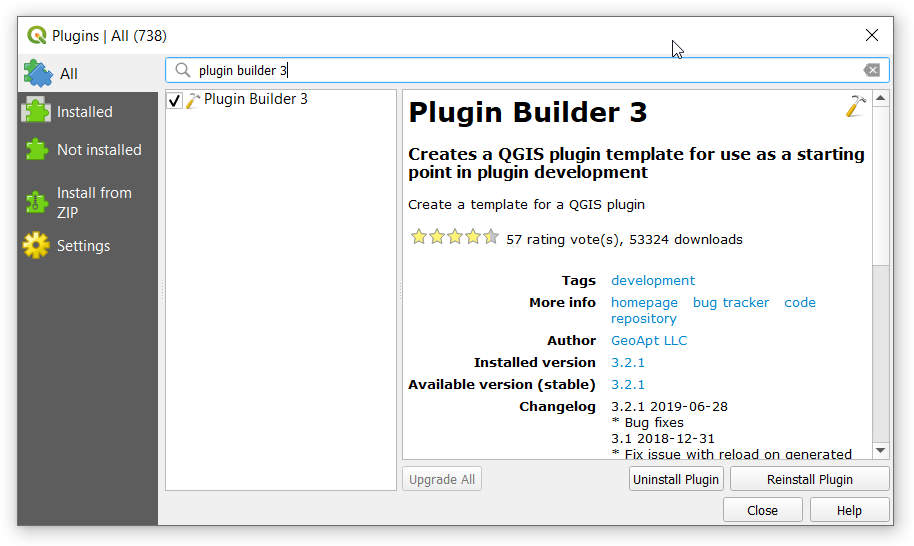

Second, run the plugin by going Plugins -> Plugin Builder in the main menu. 

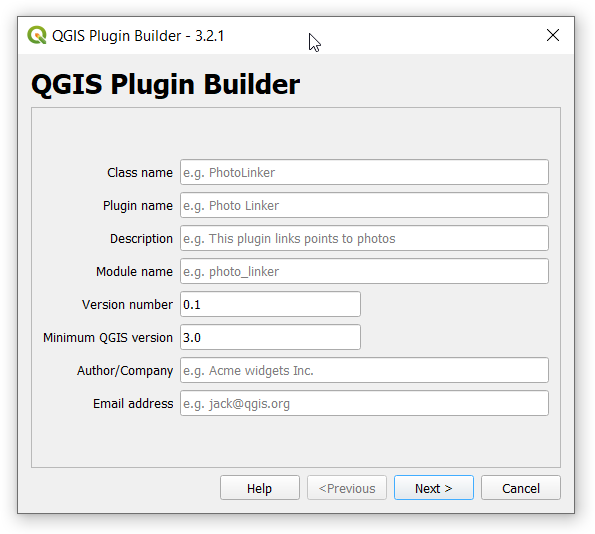

Third, input all information and next. Note that:
* Class name: this is the name of the main class for our plugin. It needs to be a valid Python class name.
* Plugin name: this is the name of the plugin in readable form. In contrast to the class name, it can contain spaces and other special characters.
* Description: a short description of what the plugin is for.
* Module name: the name of the .py file that will contain the main class for your plugin. Typically, the class name written with underscores rather than in CamelCase is used here.
* Version number & Minimum QGIS version: these are used to specify a version number for your plugin and the minimum QGIS version required to run it.
* Author/Company & Email address: here you provide information about the author of the plugin that will be used to create the copyright information at the beginning of the different files. We have no intentation of publishing this plugin, so we just use “489” here.

On the next page, you can enter a longer description of your plugin. Since this is just a toy example, we don’t bother with this here and leave the text as it is.

On the next page, you can choose between different kinds of templates for your plugin, e.g. a simple dialog box or a dock widget, meaning an actual panel that can be docked and moved inside the QGIS GUI like the other panels, e.g. the Layers panel. We here will go with the dock widget.

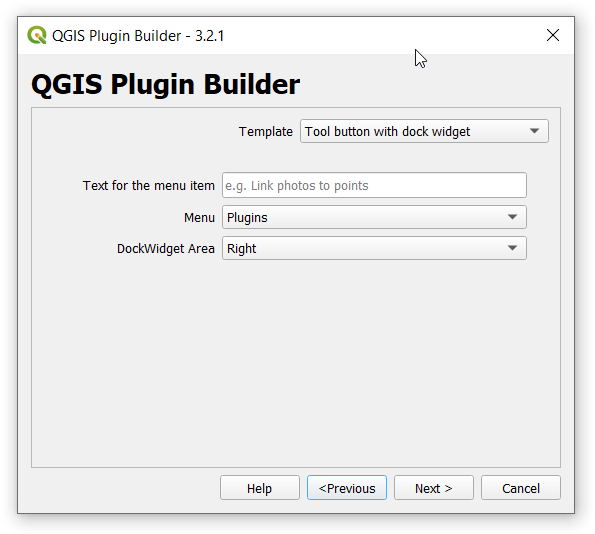

The checkboxes on the next page allow for determining which files Plugin Builder is going to create. It’s ok to leave all options checked.

The next page is specifying information that is relevant if you plan to publish your plugin, e.g. on Github. Since we are not planning this, we just leave the page unchanged.

On the last page, we can determine in which folder the new folder with the files for our plugin will be created. By default this is the default plugin folder of our QGIS installation, meaning the plugin will immediately be listed in QGIS when we start it next. If, instead of the path, you just see a dot (.), please browse to the plugins folder yourself, replacing the part directly after "C:/Users/" with your Windows user name. It is possible that the “AppData” folder in your user’s home directory is not visible in which case you will have to change your settings to show hidden files.

If we now open the new folder “\python_spatial_analysis” in the QGIS default plugin folder, you will see the following file structure:

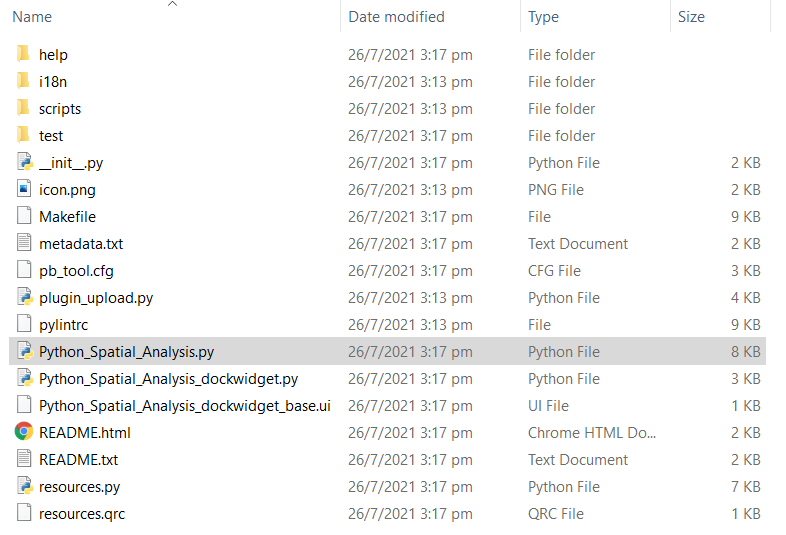

In this introduction, we won’t go into the details of features like internationalization and test code generation, so you can ignore the different subfolders and also some of the files in the main folder. The important files are:

* Python_Spatial_Analysis.py: this file defines the main class PythonSpatialAnalysis for our plugin. If you look at the code that Plugin Builder 3 generated for this class, you will see that this class has to define a number of methods to interact with QGIS and its plugin interface. One central method is the method run() that in this case here shows our dockwidget stored in instance variable self.dockwidget. 

* Python_Spatial_Analysis_dockwidget.py: this is the class that defines the main GUI widget for our plugin derived from QDockWidget. We will talk about this class in more detail in a moment because this is the class that we are going to modify to implement what needs to happen when the user interacts with the GUI of our plugin.
 
* Python_Spatial_Analysis_dockwidget_base.ui: this is the class in which the GUI for our QDockWidget is defined. We will modify it in QT Designer in a moment to adapt the GUI for our purposes.
 
* __init__.py: A file with this name needs to be contained in the main folder of each plugin and it lets QGIS know about the plugin. QGIS calls the classFactory(…) function defined in this file to create an object of the main class of the plugin (class RandomNumberGenerator in this case).

* metadata.txt: this file contains most of the info about our plugin that we entered into Plugin Builder.

## Modifying the Plugin GUI and Adding Functionality

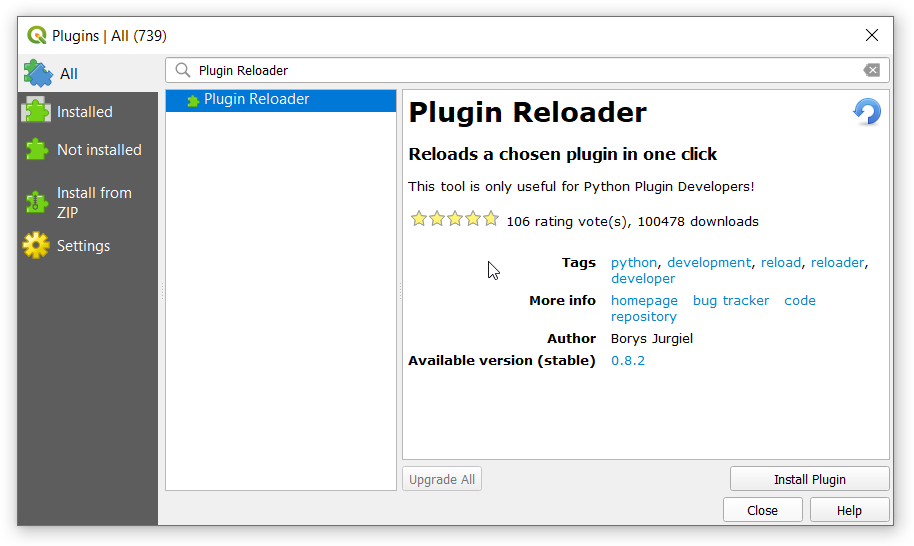

## Facility Site Selection using PULP

A facility location problem that involves determining the number and location of warehouses that are needed to supply a group of supermarkets. We’ll demonstrate how to construct a mixed-integer programming (MIP) model of this problem, implement this model in the  Python API, and then use the Optimizer to find an optimal solution.

Facility location problems have applications in a wide variety of industries. For example,  this problem can be used to find the optimal location for stores, factories, warehouses for supply chain management and logistics. Other applications range from public policy (e.g. positioning police officers in a city), telecommunications (e.g. cell towers in a network), and determining the locations for natural gas transmission equipment. 

### Problem Description 

A large supermarket chain in the Singapore needs to build warehouses for a set of supermarkets it is opening in Singapore. The locations of the supermarkets have been identified, but the locations of the warehouses have yet to be determined. Several good candidate locations for the warehouses have been identified, but decisions must be made regarding how many warehouses to open and at which candidate locations to build them.

Opening many warehouses would be advantageous as this would reduce the average distance a truck has to drive from the warehouse to the supermarket, and hence reduce the delivery cost. However, opening a warehouse has a fixed cost associated with it. In this example, our goal is to find the optimal tradeoff between delivery costs and the costs of building new facilities.


$i \in I$: Index and set of supermarket locations.

$j \in J$: Index and set of candidate warehouse locations.

$f_{j} \in \mathbb{R}^+$: Fixed cost associated with constructing facility $j \in J$.

$d_{i,j} \in \mathbb{R}^+$: Distance between facility $j \in J$ and customer $i \in I$.

$c_{i,j} \in \mathbb{R}^+$: Cost of shipping between candidate facility site $j \in J$ and customer location $i \in I$. We assume that this cost is proportional to the distance between the facility and the customer. That is, $c_{i,j} = \alpha \cdot d_{i,j}$, where $\alpha$ is the cost per km of driving, adjusted to incorporate the average number of trips a delivery truck would be expected to make over a five year period.

$select_{j} \in \{0, 1 \}$: This variable is equal to 1 if we build a facility at candidate location $j \in J$; and 0 otherwise.

$0 \leq assign_{i,j} \leq 1$: This non-negative continuous variable determines the fraction of supply received by supermarket $i \in I$ from warehouse $j \in J$.

- **Total costs**. We want to minimize the total cost to open and operate the facilities. This is the sum of the cost of opening facilities and the cost related to shipping between facilities and customers. This total cost measures the tradeoff between the cost of building a new facility and the total delivery cost over a five year period.

\begin{equation}
\text{Min} \quad Z = \sum_{j \in J} f_{j} \cdot select_{j} + \sum_{j \in J} \sum_{i \in I} c_{i,j} \cdot assign_{i,j}
\tag{0}
\end{equation}

- **Demand**. For each supermarket  $i \in I$ ensure that its demand is fulfilled. That is, the sum of the fraction received from each facility for each customer must be equal to 1:

\begin{equation}
\sum_{j \in J} assign_{i,j} = 1 \quad \forall i \in I
\tag{1}
\end{equation}

- **Shipping**. We need to ensure that we  only ship from warehouse $j \in J$,  if that facility has actually been built.

\begin{equation}
assign_{i,j} \leq select_{j} \quad \forall i \in I \quad \forall j \in J
\tag{2}
\end{equation}

### Read Shapefiles

In [94]:
%pwd

'C:\\Users\\user\\Desktop\\Projects\\qgis-vanguard'

In [95]:
Supermarkets_shp = gpd.read_file('Data/Site_Selection/Supermarkets.shp')
Warehouses_shp = gpd.read_file('Data/Site_Selection/Warehouses.shp')

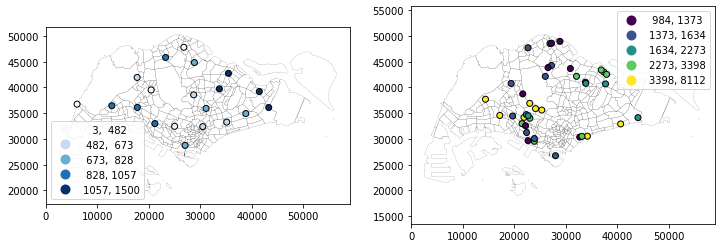

In [98]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 4))
sz.plot(ax=ax1, legend=False, facecolor="none",edgecolor="k",lw=0.1)
Supermarkets_shp.plot(ax=ax1, column='Demand', legend=True, scheme='Quantiles', legend_kwds={'fmt':'{:.0f}'}, cmap='Blues', edgecolor="k")
sz.plot(ax=ax2, legend=False, facecolor="none",edgecolor="k",lw=0.1)
Warehouses_shp.plot(ax=ax2, column='Capacity', legend=True, scheme='Quantiles', legend_kwds={'fmt':'{:.0f}'}, edgecolor="k")
plt.axis('equal')
plt.show()

### Parameters

In [99]:
# SETS
SUPERMARKETS = list(Supermarkets_shp['Shop_ID'])
WAREHOUSES =  list(Warehouses_shp['WH_ID'])

In [100]:
SUPERMARKETS

[3, 14, 7, 5, 12, 6, 11, 18, 4, 8, 17, 13, 9, 2, 10, 16, 15, 19, 1, 20]

In [101]:
WAREHOUSES

[39,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [102]:
# PARAMETERS
demand = dict(zip(SUPERMARKETS,Supermarkets_shp['Demand']))
demand

{3: 385,
 14: 782,
 7: 1156,
 5: 1217,
 12: 792,
 6: 630,
 11: 477,
 18: 483,
 4: 1045,
 8: 603,
 17: 643,
 13: 913,
 9: 396,
 2: 693,
 10: 997,
 16: 882,
 15: 1105,
 19: 740,
 1: 1500,
 20: 3}

In [103]:
actcost = dict(zip(WAREHOUSES,Warehouses_shp['Fixed_Cost']))
actcost

{39: 23272,
 1: 60975,
 2: 30975,
 3: 58200,
 4: 38200,
 5: 35415,
 6: 44235,
 7: 23292,
 8: 28200,
 9: 32560,
 10: 43357,
 11: 33907,
 12: 34235,
 13: 32982,
 14: 34235,
 15: 32341,
 16: 60975,
 17: 23907,
 18: 53292,
 19: 55883,
 20: 12000,
 21: 28200,
 22: 53907,
 23: 34235,
 24: 28200,
 25: 34235,
 26: 24379,
 27: 54379,
 28: 54379,
 29: 53272,
 30: 44235,
 31: 33272,
 32: 35233,
 33: 33907,
 34: 28200,
 35: 34349,
 36: 31857,
 37: 23292,
 38: 36581}

In [104]:
maxam = dict(zip(WAREHOUSES,Warehouses_shp['Capacity']))
maxam

{39: 2280,
 1: 4104,
 2: 1296,
 3: 3492,
 4: 8112,
 5: 1860,
 6: 2364,
 7: 1344,
 8: 1776,
 9: 1632,
 10: 1620,
 11: 1488,
 12: 2736,
 13: 1056,
 14: 1044,
 15: 1536,
 16: 3204,
 17: 1524,
 18: 2244,
 19: 3744,
 20: 5000,
 21: 3336,
 22: 984,
 23: 1248,
 24: 1920,
 25: 1632,
 26: 3000,
 27: 2352,
 28: 2688,
 29: 1776,
 30: 1536,
 31: 1644,
 32: 3816,
 33: 1008,
 34: 7308,
 35: 1824,
 36: 1392,
 37: 1188,
 38: 8052}

In [105]:
# This function determines the Euclidean distance between a facility and customer sites.
import math
def compute_distance(loc1, loc2):
    dx = loc1[0] - loc2[0]
    dy = loc1[1] - loc2[1]
    return math.sqrt(dx*dx + dy*dy)

In [106]:
SUPERMARKETS_XY = list(zip(Supermarkets_shp.geometry.x,Supermarkets_shp.geometry.y))
WAREHOUSES_XY = list(zip(Warehouses_shp.geometry.x,Warehouses_shp.geometry.y))

In [107]:
cost_per_km = 0.01

In [108]:

transp={}
for i, wh in enumerate(WAREHOUSES):
    dist=[]
    for j, _ in enumerate(SUPERMARKETS):
        dist.append(cost_per_km * compute_distance(WAREHOUSES_XY[i],SUPERMARKETS_XY[j])) # warning: distance is weighted by cost
    transp[wh] = dict(zip(SUPERMARKETS,dist))
transp

{39: {3: 77.61643923394313,
  14: 42.29376352261722,
  7: 33.85798774099471,
  5: 28.88299202163557,
  12: 63.102588551160956,
  6: 144.01599080425896,
  11: 119.76661765210872,
  18: 98.919968886445,
  4: 155.8258331791174,
  8: 93.81108828627235,
  17: 49.62933772089689,
  13: 142.96136538314633,
  9: 120.38390600622624,
  2: 143.3516264734701,
  10: 201.40049687636014,
  16: 95.99390653356501,
  15: 97.80888561537168,
  19: 98.58582284984287,
  1: 126.9125616506722,
  20: 266.15542318882245},
 1: {3: 188.0149032552678,
  14: 152.78501062590124,
  7: 122.69026646801458,
  5: 92.15980678230511,
  12: 62.35302050825839,
  6: 200.6741137421586,
  11: 164.5697297605202,
  18: 42.03546993146379,
  4: 173.90449404045572,
  8: 28.75203600859406,
  17: 97.519839715598,
  13: 132.9459986037315,
  9: 94.24583251139332,
  2: 74.16036458568323,
  10: 222.29720742965506,
  16: 188.2571900643917,
  15: 112.86491149319453,
  19: 63.63465541497613,
  1: 106.20636890984372,
  20: 288.49879690464115},

### Problem Variable

In [109]:
prob = LpProblem("FacilityLocation",LpMinimize)

### Decision Variables 

In [110]:
serv_vars = LpVariable.dicts("Service", [(i,j) for i in SUPERMARKETS for j in WAREHOUSES],0)

In [111]:
use_vars = LpVariable.dicts("UseLocation",WAREHOUSES,lowBound=0, upBound=1, cat=LpBinary)

### Objective Function

In [112]:
prob += lpSum(actcost[j] * use_vars[j] for j in WAREHOUSES) +\
lpSum(transp[j][i] * serv_vars[(i,j)] for j in WAREHOUSES for i in SUPERMARKETS)

### Constraints

In [113]:
for i in SUPERMARKETS:
    prob += lpSum(serv_vars[(i,j)] for j in WAREHOUSES) == demand[i]

In [114]:
for j in WAREHOUSES:
    prob += lpSum(serv_vars[(i,j)] for i in SUPERMARKETS) <=maxam[j] * use_vars[j]

In [115]:
for i in SUPERMARKETS:
    for j in WAREHOUSES:
        prob += serv_vars[(i,j)] <= demand[i] * use_vars[j]

In [116]:
# The problem is solved using PuLP's choice of Solver
prob.solve()

1

In [117]:
# The status of the solution is printed to the screen
print("Status:", LpStatus[prob.status])

Status: Optimal


In [118]:
TOL = 0.0001
results=[]
for i in WAREHOUSES:
    if use_vars[i].varValue > TOL:
        print(f"Establish warehouse at: {i}")
        results.append(i)

Establish warehouse at: 2
Establish warehouse at: 5
Establish warehouse at: 9
Establish warehouse at: 17
Establish warehouse at: 21
Establish warehouse at: 26
Establish warehouse at: 31
Establish warehouse at: 32
Establish warehouse at: 36


In [119]:
results

[2, 5, 9, 17, 21, 26, 31, 32, 36]

In [120]:
print("Therefore, the optimal warehouses consists of\n")
results=[]
for v in prob.variables():
    if v.varValue>0 and v.name.startswith("Service"):
        print(v.name, "=", v.varValue)

Therefore, the optimal warehouses consists of

Service_(1,_5) = 1500.0
Service_(10,_32) = 997.0
Service_(11,_9) = 477.0
Service_(12,_17) = 99.0
Service_(12,_2) = 210.0
Service_(12,_21) = 56.0
Service_(12,_31) = 427.0
Service_(13,_21) = 913.0
Service_(14,_17) = 782.0
Service_(15,_26) = 1105.0
Service_(16,_36) = 882.0
Service_(17,_17) = 643.0
Service_(18,_2) = 483.0
Service_(19,_26) = 380.0
Service_(19,_5) = 360.0
Service_(2,_21) = 693.0
Service_(20,_32) = 3.0
Service_(3,_36) = 385.0
Service_(4,_32) = 1045.0
Service_(5,_31) = 1217.0
Service_(6,_9) = 630.0
Service_(7,_26) = 1156.0
Service_(8,_2) = 603.0
Service_(9,_21) = 396.0


# References

[Geographic Data Science with PySAL and the PyData Stack](https://geographicdata.science/book/intro.html)

https://www.statsmodels.org/dev/gettingstarted.html